# Pytorch_1.1_regression  [WorldHappinessReport]

### <span style="color:purple"> Tworzenie małych prototypów o pełnej zdolności bojowej

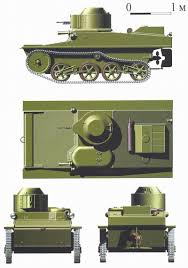

### <span style="color:blue"> Cele:
    1. podstawić prawdziwy plik danych
    2. przeliczyć zapamiętać model odpalić model
    3. zweryfikowac model czy liczy dla innych danych
    4. Cel extra - zrobić waluację modelu 





https://github.com/jcjohnson/pytorch-examples#pytorch-custom-nn-modules
10:10  10:50
11:05  

W powyższych przykładach musieliśmy ręcznie wdrożyć zarówno przejścia do przodu, jak i do tyłu naszej sieci neuronowej. Ręczne wdrożenie wstecznego przejścia nie jest wielkim problemem dla małej sieci dwuwarstwowej, ale może szybko stać się bardzo kłopotliwe dla dużych złożonych sieci.

In [1]:
import torch
import torch.nn as nn

Odpalam karte graficzną GPU

In [2]:
device = torch.device('cpu') # obliczenia robie na CPU
#device = torch.device('cuda') # obliczenia robie na GPU

In [3]:
import pandas as pd

df = pd.read_csv('/home/wojciech/Pulpit/1/WorldHappinessReport.csv')
df.head(3)

,Unnamed: 0,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
0,0,Afghanistan,Southern Asia,153.0,3.575,0.31982,0.30285,0.30335,0.23414,0.09719,0.36510,1.95210,2015.0
1,1,Albania,Central and Eastern Europe,95.0,4.959,0.87867,0.80434,0.81325,0.35733,0.06413,0.14272,1.89894,2015.0
2,2,Algeria,Middle East and Northern Africa,68.0,5.605,0.93929,1.07772,0.61766,0.28579,0.17383,0.07822,2.43209,2015.0


In [4]:
N, D_in, H, D_out = 64, 1000, 100, 10

Powyżej zostały określone parametry aby tensor zmiennych niezależnych i tensor wynikowy były odpowiednie 

x: 64 obserwacji i 1000 zmiennych

y: 64 obserwacji i 10 zmiennych

### <span style="color:blue">2. Usuwanie pustych komórek NaN </span>
Sieci nieuronowe nie lubiś pustych komórek NaN -jak tego nie zrobimy wyjdzie nam NaN

In [5]:
df = df.dropna(how ='any')
df.isnull().sum()

Unnamed: 0                       0
Country                          0
Region                           0
Happiness Rank                   0
Happiness Score                  0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Dystopia Residual                0
Year                             0
dtype: int64

### Tworzy losowe dane wejściowe i wyjściowe 

In [6]:
X = torch.tensor((df['Economy (GDP per Capita)'],df['Freedom'],df['Trust (Government Corruption)']), dtype=torch.float)
X

tensor([[0.3198, 0.8787, 0.9393,  ..., 0.5917, 0.6364, 0.3758],
        [0.2341, 0.3573, 0.2858,  ..., 0.2495, 0.4616, 0.3364],
        [0.0972, 0.0641, 0.1738,  ..., 0.0568, 0.0782, 0.0954]])

#### <span style="color:blue"> 3.1 TRansponuje wektor zmiennych niezależnych aby stał się kolumną</span>

In [7]:
X = torch.transpose(X.flip(0),0,1)
X

tensor([[0.0972, 0.2341, 0.3198],
        [0.0641, 0.3573, 0.8787],
        [0.1738, 0.2858, 0.9393],
        ...,
        [0.0568, 0.2495, 0.5917],
        [0.0782, 0.4616, 0.6364],
        [0.0954, 0.3364, 0.3758]])

### <span style="color:blue">4. Przekształcanie na tensor zmiennych zależnych</span>
Jako dane wynikowe wybrano zmienną: 'Happiness Score'

In [8]:
y = torch.tensor((df['Happiness Score']), dtype=torch.float)
#y

#### <span style="color:blue"> 4.1 TRansponuje wektor wynikowy aby stał się kolumną</span>

In [9]:
y = y.view(y.shape[0],1)
y[:12]

tensor([[3.5750],
        [4.9590],
        [5.6050],
        [4.0330],
        [6.5740],
        [4.3500],
        [7.2840],
        [7.2000],
        [5.2120],
        [5.9600],
        [4.6940],
        [5.8130]])

In [10]:
print('X ',X.size())
print('y ',y.size())

X  torch.Size([469, 3])
y  torch.Size([469, 1])


### Tworzy wagi losowe dla x i y

In [11]:
N, D_in = X.shape
N, D_out = y.shape

In [12]:
H = 10
device = torch.device('cpu')

In [13]:
w1 = torch.randn(D_in, H, device=device)
w2 = torch.randn(H, D_out, device=device)

In [14]:
w1[:2]

tensor([[-1.6132, -1.3645, -1.3592, -0.0723, -0.2487, -0.5041, -0.0603,  0.5292,
          1.6465,  0.4280],
        [ 0.5460, -0.4100, -1.5326, -0.9086,  1.1751, -0.3382,  0.3155,  0.1122,
          0.3900,  0.8720]])

In [15]:
print('w1 dla x: ', w1.shape)
print('w2 dla y: ', w2.shape)

w1 dla x:  torch.Size([3, 10])
w2 dla y:  torch.Size([10, 1])


### Definiowanie nauki - NAUKA MODELU

In [16]:
epochs = 2500
aggregated_losses = []


learning_rate = 0.0001     #<= wielkość kroków
for t in range(epochs):         #<= ilość epok
 
  h = X.mm(w1)               #<= zwykłe mnożenie macierzy x*w1
  h_relu = h.clamp(min=0)    #<= wyznaczenie ograniczenia do min=0
  y_pred = h_relu.mm(w2)     #<= pomnożenie przez daje predykcję y_pred
## Wyznaczenie straty (loss) jako wskaźnika r2
## Strata Loss jest skalarem i jest przechowywana w tensorze PyTorcha(); 
## możemy uzyskać jego wartość jako liczbę w języku Python za pomocą loss.item ().
  loss = (y_pred - y).pow(2).sum()
  
  aggregated_losses.append(loss) ## potrzebne do wykresu

  print('Krok:',t, loss.item())        # Dla każdej pentli drukuje wynik r2
  # Backprop do obliczania gradientów w1 i w2 w odniesieniu do strat
  grad_y_pred = 2.0 * (y_pred - y)      #błąd modelu razy 2
  grad_w2 = h_relu.t().mm(grad_y_pred)  #
  grad_h_relu = grad_y_pred.mm(w2.t())
  grad_h = grad_h_relu.clone()
  grad_h[h < 0] = 0
  grad_w1 = X.t().mm(grad_h)

  # Zaktualizuj wagi przy użyciu spadku gradientu
  w1 -= learning_rate * grad_w1
  w2 -= learning_rate * grad_w2


Krok: 0 23992.55078125
Krok: 1 839.9432373046875
Krok: 2 677.2001342773438
Krok: 3 671.9268188476562
Krok: 4 668.744140625
Krok: 5 665.714599609375
Krok: 6 662.75390625
Krok: 7 659.8572387695312
Krok: 8 657.022705078125
Krok: 9 654.248779296875
Krok: 10 651.5341796875
Krok: 11 648.8765258789062
Krok: 12 646.2750854492188
Krok: 13 643.7282104492188
Krok: 14 641.2344360351562
Krok: 15 638.7923583984375
Krok: 16 636.4005737304688
Krok: 17 634.058349609375
Krok: 18 631.7642211914062
Krok: 19 629.516845703125
Krok: 20 627.3151245117188
Krok: 21 625.1581420898438
Krok: 22 623.0447998046875
Krok: 23 620.9735107421875
Krok: 24 618.9442138671875
Krok: 25 616.9551391601562
Krok: 26 615.0057983398438
Krok: 27 613.0946655273438
Krok: 28 611.221435546875
Krok: 29 609.3848876953125
Krok: 30 607.584228515625
Krok: 31 605.8187866210938
Krok: 32 604.0875854492188
Krok: 33 602.3897094726562
Krok: 34 600.724365234375
Krok: 35 599.0911254882812
Krok: 36 597.4887084960938
Krok: 37 595.9168090820312
Krok: 3

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch')

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

### Prognoza na podstawie modelu
- poprostu podstawiamy te same równania które były w modelu 
- Poniższy wynik loss pokazuje ostatnią sekwencje modelu
- Loss pokazuuje ile myli się model (loss = suma kwadratu błedów) po ostatniej sekwencji uczenia się 

In [18]:
with torch.no_grad():
    y_pred = h_relu.mm(w2)  
    loss = (y_pred - y).pow(2).sum()

    print(f'Loss train_set: {loss:.8f}')

Loss train_set: 380.96923828


Ponieważ ustaliliśmy, że nasza warstwa wyjściowa będzie zawierać 1 neuron, każda prognoza będzie zawierać 1 wartości. Przykładowo pierwsze 5 przewidywanych wartości wygląda następująco:

In [19]:
y_pred[:5]

tensor([[2.4883],
        [4.3975],
        [4.2834],
        [3.4128],
        [5.2886]])

Celem takich prognoz jest to, że jeśli rzeczywisty wynik wynosi 0, wartość przy indeksie 0 powinna być wyższa niż wartość przy indeksie 1 i odwrotnie. Możemy pobrać indeks największej wartości z listy za pomocą następującego skryptu:

- np.argmax - Zwraca wskaźniki wartości maksymalnych wzdłuż osi.

<span style="color:red"> NIC Z TEGO NIE ROZUMIEM

In [20]:
import numpy as np
y_pred2 = np.argmax(y_pred, axis=1)
y_pred2[:6]

tensor([0, 0, 0, 0, 0, 0])

Powyższe równanie zwraca wskaźniki wartości maksymalnych wzdłuż osi. 

Ponieważ na liście pierwotnie przewidywanych wyników y_pred dla pierwszych pięciu rekordów wartości przy zerowych indeksach są większe niż wartości przy pierwszych indeksach, możemy zobaczyć 0 w pierwszych pięciu wierszach przetworzonych danych wyjściowych.

In [21]:
y_pred[:4]

tensor([[2.4883],
        [4.3975],
        [4.2834],
        [3.4128]])

### Zapisujemy cały model
TA siec jest tak prosta, że nie można zrobić jej zapisu - bo nie ma zapisanej swojej definicji 

## Użycie bojowe modelu
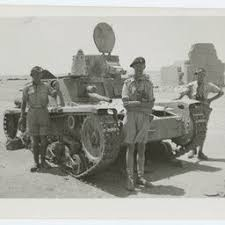



### Podstawiając inne zmienne niezależne można uzyskać wektor zmiennych wyjściowych
Wybieramy sobie jakąś losowy rekord 1% naszej polulacji

In [22]:
df2 = df.sample(frac = 0.01, random_state=10) 
print(df2.shape)
print()
df2


(5, 13)



,Unnamed: 0,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
315,315,Tunisia,Middle East and Northern Africa,98.0,5.045,0.97724,0.43165,0.59577,0.23553,0.08170,0.03936,2.68413,2016.0
149,149,Trinidad And Tobago,Latin America and Caribbean,41.0,6.168,1.21183,1.18354,0.61483,0.55884,0.01140,0.31844,2.26882,2015.0
198,198,Congo (Kinshasa),Sub-Saharan Africa,125.0,4.272,0.05661,0.80676,0.18800,0.15602,0.06075,0.25458,2.74924,2016.0
167,167,Algeria,Middle East and Northern Africa,38.0,6.355,1.05266,0.83309,0.61804,0.21006,0.16157,0.07044,3.40904,2016.0
48,48,Gabon,Sub-Saharan Africa,143.0,3.896,1.06024,0.90528,0.43372,0.31914,0.11091,0.06822,0.99895,2015.0


Bierzemy te same zmienne co w modelu

In [40]:
X_exp = torch.tensor(df2[['Economy (GDP per Capita)','Freedom','Trust (Government Corruption)']].values)
print(X_exp.shape)
print(X_exp)
print()


torch.Size([5, 3])
tensor([[0.9772, 0.2355, 0.0817],
        [1.2118, 0.5588, 0.0114],
        [0.0566, 0.1560, 0.0607],
        [1.0527, 0.2101, 0.1616],
        [1.0602, 0.3191, 0.1109]], dtype=torch.float64)



X_exp to Duble tensor - przerabiamy go na Float Tensor

In [46]:
X_exp = X_exp.type(torch.FloatTensor)
X_exp

tensor([[0.9772, 0.2355, 0.0817],
        [1.2118, 0.5588, 0.0114],
        [0.0566, 0.1560, 0.0608],
        [1.0527, 0.2101, 0.1616],
        [1.0602, 0.3191, 0.1109]])

Zmienna wynikowa y

In [29]:
w01 = np.random.randn(3, 5)

In [49]:
w01 = torch.tensor(w01)
w01 = w01.type(torch.FloatTensor)
w01

/home/wojciech/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor([[-0.8869, -0.8968, -2.4913,  0.2018, -0.2955],
        [-0.7605, -0.6304,  0.7503, -0.6016,  0.7678],
        [ 1.5129,  0.6051,  0.8185,  0.6681,  1.2359]])

In [54]:
y_exp = torch.tensor(df2['Happiness Score'].values)
y_exp = y_exp.type(torch.FloatTensor)
y_exp

tensor([5.0450, 6.1680, 4.2720, 6.3550, 3.8960])

In [55]:
y_exp = y_exp.view(y_exp.shape[0],1)
y[:12]

tensor([[3.5750],
        [4.9590],
        [5.6050],
        [4.0330],
        [6.5740],
        [4.3500],
        [7.2840],
        [7.2000],
        [5.2120],
        [5.9600],
        [4.6940],
        [5.8130]])

In [57]:
print("X_exp:",X_exp.shape)
print("w1:",w1.shape)

X_exp: torch.Size([5, 3])
w1: torch.Size([3, 10])


#### Podstawiamy do gotowego, zrobionego wczesniej modelu

In [59]:

    h = X_exp.mm(w1)               #<= zwykłe mnożenie macierzy x*w1
    h_relu = h.clamp(min=0)        #<= wyznaczenie ograniczenia do min=0
    y_pred_AB = h_relu.mm(w2)    

    loss = (y_pred_AB - y_exp).pow(2).sum()

    print(f'Loss train_set: {loss:.8f}')

Loss train_set: 17.88477898


In [60]:
  h = X.mm(w1)               #<= zwykłe mnożenie macierzy x*w1
  h_relu = h.clamp(min=0)    #<= wyznaczenie ograniczenia do min=0
  y_pred = h_relu.mm(w2)

#### Wektor wynikowy

In [61]:
y_pred_AB

tensor([[3.5351],
        [6.1301],
        [1.4422],
        [3.6204],
        [4.2392]])

In [62]:
y_exp

tensor([[5.0450],
        [6.1680],
        [4.2720],
        [6.3550],
        [3.8960]])

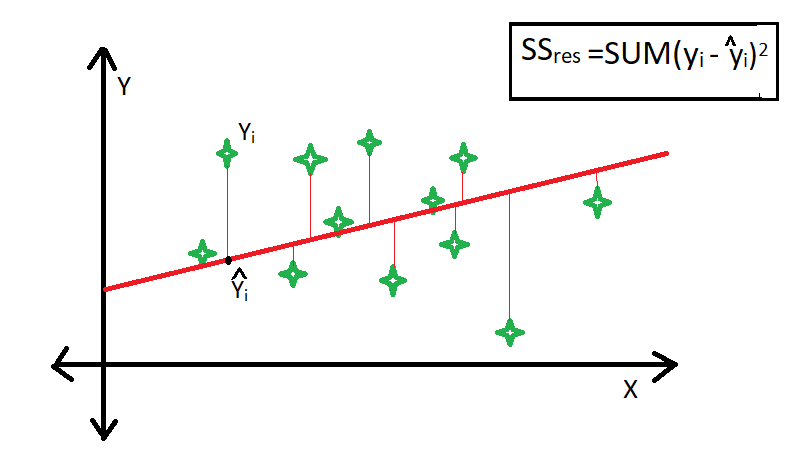

## Obliczenie parametru R2

In [66]:
(y_exp - y_pred_AB).pow(2).sum()

tensor(17.8848)